In [1]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 29.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 23.1 MB/s eta 0:00

In [2]:
from datasets import load_dataset
import numpy as np
import pandas as pd
import pyarrow
import torch
import torchtext
from tqdm import tqdm
import transformers
from torch.utils.data import DataLoader
from torch import nn
import time
import warnings
warnings.filterwarnings("ignore")

In [3]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [4]:
import random
def seed_everything(seed=73):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(1234)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic = True

print("PyTorch Version: ", torch.__version__)
print("torchtext Version: ", torchtext.__version__)
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'}.")

PyTorch Version:  2.0.0+cu118
torchtext Version:  0.15.1+cpu
Using GPU.


In [5]:
dataset  = load_dataset("go_emotions", "simplified")

train = dataset['train'].to_pandas()
validation = dataset['validation'].to_pandas()
test = dataset['test'].to_pandas()

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
initial_emotion_dict = {0: 'admiration',
1: 'amusement',
2: 'anger',
3: 'annoyance',
4: 'approval',
5: 'caring',
6: 'confusion',
7: 'curiosity',
8: 'desire',
9: 'disappointment',
10: 'disapproval',
11: 'disgust',
12: 'embarrassment',
13: 'excitement',
14: 'fear',
15: 'gratitude',
16: 'grief',
17: 'joy',
18: 'love',
19: 'nervousness',
20: 'optimism',
21: 'pride',
22: 'realization',
23: 'relief',
24: 'remorse',
25: 'sadness',
26: 'surprise',
27: 'neutral'}

n_labels = len(initial_emotion_dict)+1

In [7]:
subsets = train.labels.value_counts().index[0:14]
print(subsets) #returns most frequent 13 indexes + other_emotions for the rest.
kept_labels = [index[0] for index in subsets]
print(kept_labels)
kept_labels = np.array(kept_labels)

Index([[27], [0], [4], [15], [1], [3], [18], [10], [7], [2], [20], [6], [17],
       [25]],
      dtype='object')
[27, 0, 4, 15, 1, 3, 18, 10, 7, 2, 20, 6, 17, 25]


In [8]:
N_CLASSES = len(kept_labels)+1  #for other_emotions

not_kept_labels = np.arange(0,28)
not_kept_labels = np.delete(not_kept_labels, kept_labels)

def one_hot_encoder(df):
    one_hot_encoding = []
    for i in tqdm(range(len(df))):
        temp = [0]*n_labels
        label_indices = df.iloc[i]["labels"]
        for index in label_indices:
            if index in kept_labels:
              temp[index] = 1
            else:
              temp[n_labels-1] = 1 #other_emotions become 1
        temp = np.delete(temp,not_kept_labels)
        one_hot_encoding.append(temp)
    return pd.DataFrame(one_hot_encoding)

In [9]:
train_labels = one_hot_encoder(train)
valid_labels = one_hot_encoder(validation)
test_labels = one_hot_encoder(test)




  0%|          | 0/43410 [00:00<?, ?it/s]


  3%|▎         | 1498/43410 [00:00<00:02, 14972.02it/s]


  7%|▋         | 2996/43410 [00:00<00:02, 14931.39it/s]


 10%|█         | 4490/43410 [00:00<00:02, 14305.91it/s]


 14%|█▎        | 5930/43410 [00:00<00:02, 14339.11it/s]


 17%|█▋        | 7366/43410 [00:00<00:02, 14003.10it/s]


 20%|██        | 8791/43410 [00:00<00:02, 14081.94it/s]


 23%|██▎       | 10201/43410 [00:00<00:02, 13430.87it/s]


 27%|██▋       | 11635/43410 [00:00<00:02, 13706.92it/s]


 30%|███       | 13114/43410 [00:00<00:02, 14033.45it/s]


 33%|███▎      | 14522/43410 [00:01<00:02, 13676.24it/s]


 37%|███▋      | 15952/43410 [00:01<00:01, 13858.99it/s]


 40%|███▉      | 17357/43410 [00:01<00:01, 13914.17it/s]


 43%|████▎     | 18752/43410 [00:01<00:01, 13883.67it/s]


 46%|████▋     | 20182/43410 [00:01<00:01, 14005.93it/s]


 50%|████▉     | 21682/43410 [00:01<00:01, 14300.11it/s]


 53%|█████▎    | 23114/43410 [00:01<00:01, 14121.52it/s]


 57%|█████▋    

In [10]:
train = pd.concat([train, train_labels], axis=1)
valid = pd.concat([validation, valid_labels], axis=1)
test = pd.concat([test, test_labels], axis=1)

In [11]:
train.head()

,text,labels,id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,My favourite food is anything I didn't have to...,[27],eebbqej,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,"Now if he does off himself, everyone will thin...",[27],ed00q6i,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,WHY THE FUCK IS BAYLESS ISOING,[2],eezlygj,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,To make her feel threatened,[14],ed7ypvh,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Dirty Southern Wankers,[3],ed0bdzj,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [12]:
emotion_dict = dict()
for index,value in enumerate(np.sort(kept_labels)):
    emotion_dict[index] = initial_emotion_dict[value]
emotion_dict[len(kept_labels)] = 'other_emotions'
emotion_dict

{0: 'admiration',
 1: 'amusement',
 2: 'anger',
 3: 'annoyance',
 4: 'approval',
 5: 'confusion',
 6: 'curiosity',
 7: 'disapproval',
 8: 'gratitude',
 9: 'joy',
 10: 'love',
 11: 'optimism',
 12: 'sadness',
 13: 'neutral',
 14: 'other_emotions'}

In [13]:
        # 'learning_rate': {
        #     'values': [5e-5, 3e-5]
        # },
        # 'batch_size': {
        #     'values': [32, 64]
        # },
        # 'epochs':{'value': 10},
        # 'dropout':{
        #     'values': [0.3, 0.4, 0.5]
        # },
        # 'tokenizer_max_len': {'value': 40}

LEARNING_RATE = 5e-5
MAX_LEN = 40
BATCH_SIZE = 64
N_EPOCHS = 10
N_LAYERS = 4
BIDIRECTIONAL = True
DROPOUT = 0.3
HIDDEN_DIM = 256

In [14]:
from transformers import BertTokenizer, BertModel
from transformers import AdamW, get_linear_schedule_with_warmup

bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class GoEmotionDataset:
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels

        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]

        inputs = self.tokenizer.__call__(text,
                                        None,
                                        add_special_tokens=True,
                                        max_length=self.max_len,
                                        padding="max_length",
                                        truncation=True,
                                        )
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]

        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "labels": torch.tensor(label, dtype=torch.long)
        }

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
def build_dataset(tokenizer_max_len):
    train_dataset = GoEmotionDataset(train.text.tolist(), train[range(N_CLASSES)].values.tolist(), tokenizer, tokenizer_max_len)
    valid_dataset = GoEmotionDataset(valid.text.tolist(),valid[range(N_CLASSES)].values.tolist(), tokenizer, tokenizer_max_len)
    test_dataset = GoEmotionDataset(test.text.tolist(),test[range(N_CLASSES)].values.tolist(), tokenizer, tokenizer_max_len)

    return train_dataset, valid_dataset, test_dataset

In [16]:
sample_train_dataset, _ ,_ = build_dataset(40)
print(sample_train_dataset[0])
len(sample_train_dataset)

{'ids': tensor([ 101, 2026, 8837, 2833, 2003, 2505, 1045, 2134, 1005, 1056, 2031, 2000,
        5660, 2870, 1012,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0]), 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'labels': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])}


43410

In [17]:
def build_dataloader(train_dataset, valid_dataset, test_dataset, batch_size):
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    return train_data_loader, valid_data_loader, test_data_loader

train_dataset, valid_dataset, test_dataset = build_dataset(MAX_LEN)
train_dataloader, valid_dataloader, test_dataloader = build_dataloader(train_dataset,valid_dataset, test_dataset, BATCH_SIZE)

In [18]:
class BERTClass(torch.nn.Module):
    def __init__(self, n_train_steps, hidden_dim, n_classes, n_layers, bidirectional, dropout):
        super(BERTClass, self).__init__()
        self.bert = bert_model
        self.embedding_dim = bert_model.config.to_dict()['hidden_size']

        self.rnn = nn.GRU(self.embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          # dropout = 0 if n_layers < 2 else dropout, #The batch_first parameter is set to True, which means that the input and output tensors will have the batch dimension as the first dimension.
                          batch_first = True) 
        
        self.dropout = nn.Dropout(dropout)             
     
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, n_classes)

        self.n_train_steps = n_train_steps

        self.step_scheduler_after = "batch"
        
        
    def forward(self, ids, mask):

        embedded = self.bert(input_ids=ids,attention_mask=mask)[0]

        _, hidden = self.rnn(embedded)
                
        if self.rnn.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.out(hidden)

n_train_steps = int(len(train_dataset) / BATCH_SIZE * 10)
model = BERTClass(n_train_steps,HIDDEN_DIM,N_CLASSES,N_LAYERS,BIDIRECTIONAL,DROPOUT)
model.to(DEVICE)

BERTClass(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [19]:
def loss_fn(outputs, targets):
    criterion = nn.BCEWithLogitsLoss()
    criterion = criterion.to(DEVICE)
    loss = criterion(outputs.view(-1, N_CLASSES), 
                  targets.float().view(-1, N_CLASSES))
    if targets is None:
        return None
    return loss

optimizer = torch.optim.AdamW(params =  model.parameters(), lr=LEARNING_RATE)

In [20]:
def ret_scheduler(optimizer, num_train_steps):
    sch = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps)
    return sch

def train_fn(model, train_dataloader, optimizer, scheduler):
    
    train_loss = 0.0
    model.train()

    for bi, d in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        ids = d["ids"]
        mask = d["mask"]
        targets = d["labels"]

        ids = ids.to(DEVICE, dtype=torch.long)
        mask = mask.to(DEVICE, dtype=torch.long)
        targets = targets.to(DEVICE, dtype=torch.float)

        optimizer.zero_grad()
        outputs = model(ids=ids, mask=mask)
        
        loss = loss_fn(outputs, targets)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        scheduler.step()

        model.zero_grad()
        
    return train_loss/len(train_dataloader)

In [21]:
def eval_fn(data_loader, model):
    eval_loss = 0.0
    model.eval()
    fin_targets = []
    fin_outputs = []
    with torch.no_grad():
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d["ids"]
            mask = d["mask"]
            targets = d["labels"]

            ids = ids.to(DEVICE, dtype=torch.long)
            mask = mask.to(DEVICE, dtype=torch.long)
            targets = targets.to(DEVICE, dtype=torch.float)

            outputs = model(ids=ids, mask=mask)
            loss = loss_fn(outputs, targets)
            eval_loss += loss.item()
            fin_targets.extend(targets)
            fin_outputs.extend(torch.sigmoid(outputs))
            
    return eval_loss/len(data_loader), fin_outputs, fin_targets

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [23]:
scheduler = ret_scheduler(optimizer, n_train_steps)

best_train_loss = float('inf')
print(f"Using {'GPU' if str(DEVICE) == 'cuda' else 'CPU'} for training.")

for epoch in range(N_EPOCHS):
    print(f'Epoch: {epoch+1:02}')
    start_time = time.time()
    
    train_loss = train_fn(model, train_dataloader, optimizer, scheduler)
    print(f'\tTrain Loss: {train_loss:.3f}')

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

Using GPU for training.
Epoch: 01


100%|██████████| 679/679 [04:54<00:00,  2.31it/s]

	Train Loss: 0.214
Epoch: 02



100%|██████████| 679/679 [04:58<00:00,  2.27it/s]

	Train Loss: 0.147
Epoch: 03



100%|██████████| 679/679 [04:58<00:00,  2.27it/s]

	Train Loss: 0.123
Epoch: 04



100%|██████████| 679/679 [04:58<00:00,  2.28it/s]

	Train Loss: 0.100
Epoch: 05



100%|██████████| 679/679 [04:58<00:00,  2.28it/s]

	Train Loss: 0.080
Epoch: 06



100%|██████████| 679/679 [04:58<00:00,  2.28it/s]

	Train Loss: 0.063
Epoch: 07



100%|██████████| 679/679 [04:58<00:00,  2.27it/s]

	Train Loss: 0.051
Epoch: 08



100%|██████████| 679/679 [04:58<00:00,  2.28it/s]

	Train Loss: 0.042
Epoch: 09



100%|██████████| 679/679 [04:58<00:00,  2.28it/s]

	Train Loss: 0.036
Epoch: 10



100%|██████████| 679/679 [04:58<00:00,  2.27it/s]

	Train Loss: 0.032


In [24]:
valid_loss, valid_outputs, valid_targets=eval_fn(valid_dataloader,model)

100%|██████████| 85/85 [00:12<00:00,  7.06it/s]


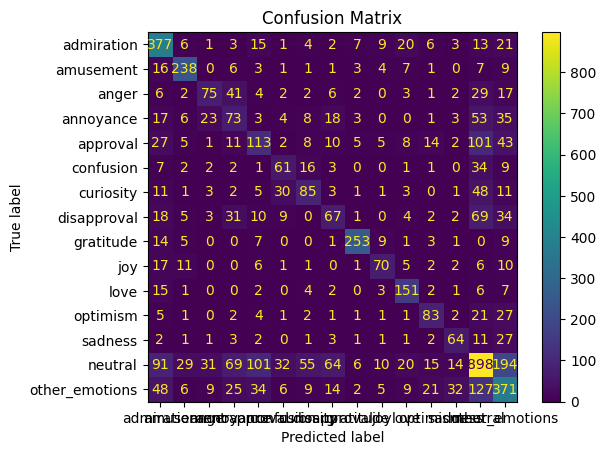

                precision    recall  f1-score   support

    admiration       0.74      0.75      0.74       488
     amusement       0.75      0.81      0.77       303
         anger       0.50      0.38      0.44       195
     annoyance       0.33      0.31      0.32       303
      approval       0.38      0.31      0.34       397
     confusion       0.42      0.43      0.42       152
     curiosity       0.48      0.43      0.45       248
   disapproval       0.37      0.27      0.31       292
     gratitude       0.94      0.88      0.91       358
           joy       0.60      0.51      0.55       172
          love       0.72      0.81      0.76       252
      optimism       0.60      0.52      0.56       209
       sadness       0.54      0.54      0.54       143
       neutral       0.65      0.55      0.60      1766
other_emotions       0.51      0.57      0.54      1036

     micro avg       0.59      0.55      0.57      6314
     macro avg       0.57      0.54      0.55 

In [25]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, auc, roc_curve 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def compute_metrics(labels,preds):
    preds = torch.stack(preds)
    preds = preds.cpu().detach().numpy()
    labels = torch.stack(labels)
    labels = labels.cpu().detach().numpy()
    
    assert len(preds) == len(labels)
    results = dict()

    fpr_micro, tpr_micro, _ = roc_curve(labels.ravel(), preds.ravel())
    results["auc_micro"] = auc(fpr_micro, tpr_micro)

    cm = confusion_matrix(labels.argmax(axis=1),preds.argmax(axis=1)) #confusion matrix of adjusted threshold
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=emotion_dict.values())
    disp.plot()
    plt.title("Confusion Matrix")
    plt.show()

    labels = labels.tolist()
    print(classification_report(labels,preds,target_names=emotion_dict.values()))
    
    results["accuracy"] = accuracy_score(labels, preds)

    results["macro_precision"], results["macro_recall"], results[
        "macro_f1"], _ = precision_recall_fscore_support(
        labels, preds, average="macro")

    results["micro_precision"], results["micro_recall"], results[
        "micro_f1"], _ = precision_recall_fscore_support(
        labels, preds, average="micro")

    results["weighted_precision"], results["weighted_recall"], results[
        "weighted_f1"], _ = precision_recall_fscore_support(
        labels, preds, average="weighted")

    return results

threshold = 0.6
valid_preds = [torch.ceil(output-threshold) for output in valid_outputs]

result = compute_metrics(valid_targets,valid_preds)

print("validation loss:", valid_loss)
print("validation metric results:", result)

In [26]:
test_loss, test_outputs, test_targets=eval_fn(test_dataloader,model)

100%|██████████| 85/85 [00:12<00:00,  7.07it/s]


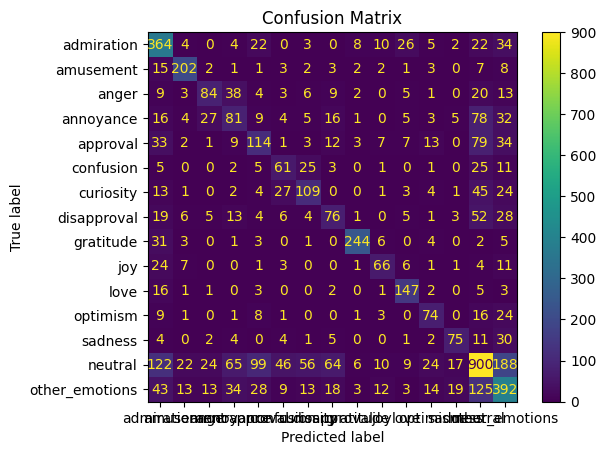

                precision    recall  f1-score   support

    admiration       0.68      0.70      0.69       504
     amusement       0.77      0.81      0.79       264
         anger       0.53      0.42      0.47       198
     annoyance       0.34      0.29      0.31       320
      approval       0.37      0.36      0.36       351
     confusion       0.39      0.44      0.41       153
     curiosity       0.52      0.48      0.50       284
   disapproval       0.39      0.32      0.35       267
     gratitude       0.94      0.89      0.92       352
           joy       0.60      0.56      0.58       161
          love       0.79      0.82      0.80       238
      optimism       0.53      0.50      0.52       186
       sadness       0.63      0.54      0.58       156
       neutral       0.67      0.55      0.61      1787
other_emotions       0.53      0.56      0.54      1055

     micro avg       0.60      0.56      0.58      6276
     macro avg       0.58      0.55      0.56 

In [27]:
test_preds = [torch.ceil(output-threshold) for output in test_outputs]

result = compute_metrics(test_targets,test_preds)

print("test loss:", test_loss)
print("test metric results:", result)

In [28]:
def predict_sentiment(model, sentence):
    max_len = 40

    inputs = tokenizer.__call__(sentence,
                        None,
                        add_special_tokens=True,
                        max_length=max_len,
                        padding="max_length",
                        truncation=True,
                        )
    
    ids = inputs['input_ids']
    ids = torch.tensor(ids, dtype=torch.long)
    mask = inputs['attention_mask']
    mask = torch.tensor(mask, dtype=torch.long)

    ids = ids.to(DEVICE, dtype=torch.long).unsqueeze(0)
    mask = mask.to(DEVICE, dtype=torch.long).unsqueeze(0)
    print(ids)
    print(mask)

    model.eval()
    logits = model(ids=ids, mask=mask)
    print(logits)
    result = torch.sigmoid(logits)
    print(result)

    threshold = 0.6
    valid_result = torch.ceil(result-threshold)

    return valid_result

In [29]:
predict_sentiment(model,"Troll, bro. They know they're saying stupid shit. The motherfucker does nothing but stink up libertarian subs talking shit")

tensor([[  101, 18792,  1010, 22953,  1012,  2027,  2113,  2027,  1005,  2128,
          3038,  5236,  4485,  1012,  1996,  2388, 11263,  9102,  2515,  2498,
          2021, 27136,  2039, 19297,  4942,  2015,  3331,  4485,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]],
       device='cuda:0')
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
tensor([[-5.0910, -5.0353,  3.3732, -2.4940, -6.4359, -5.7504, -5.6888, -4.7927,
         -5.8666, -5.4164, -5.5922, -6.1645, -5.6462, -3.2789, -3.7315]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[0.0061, 0.0065, 0.9669, 0.0763, 0.0016, 0.0032, 0.0034, 0.0082, 0.0028,
         0.0044, 0.0037, 0.0021, 0.0035, 0.0363, 0.0234]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)


tensor([[-0., -0., 1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.]],
       device='cuda:0', grad_fn=<CeilBackward0>)

In [30]:
#  tokenizer.encode(train['text'][43407])
#  print(train['text'][43407])
text = [101, 18792,  1010, 22953,  1012,  2027,  2113,  2027,  1005,  2128,
          3038,  5236,  4485,  1012,  1996,  2388, 11263,  9102,  2515,  2498,
          2021, 27136,  2039, 19297,  4942,  2015,  3331,  4485,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]
tokenizer.decode(tokenizer.encode(text))

"[CLS] [CLS] troll, bro. they know they're saying stupid shit. the motherfucker does nothing but stink up libertarian subs talking shit [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [SEP]"